# Training LeNet-5 on CIFAR-10
In this notebook, we will try to deploy the famous LeNet-5 to solve a simple image classification task, the CIFAR-10. CIFAR-10 is composed of 60K images from 10 categories. After splitting the dataset, we have 45K/5K/10K images for train/valiation/test dataset.
In this notebook, only the labels of training/validation dataset is visible to you, so you can use the training and validation data to tune your model. After you submitted your model, your final grade will be determined on the model performance on the holdout test dataset.

### Step 0 Setting up LeNet-5 model
As you have set up the LeNet-5 model in Homework 1, we will just move the implementation of LeNet-5 model here, so you can use it for this homework.

In [12]:
import argparse
import os, sys
import time
import datetime

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np

In [13]:
import math
# Create the neural network module: LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm1d(120)
        self.bn4 = nn.BatchNorm1d(84)
        #self._initialize_weights()
        
    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        #out = self.swish(self.conv1(x))
        out = F.relu(self.conv1(x))
        out = self.bn1(out)
        out = F.max_pool2d(out, 2)
        #out = self.swish(self.conv2(out))
        out = F.relu(self.conv2(out))
        out = self.bn2(out)
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        #out = self.swish(self.fc1(out))
        out = F.relu(self.fc1(out))
        out = self.bn3(out)
        #out = self.swish(self.fc2(out))
        out = F.relu(self.fc2(out))
        out = self.bn4(out)
        out = self.fc3(out)
        return out


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #nn.init.kaiming_normal_(m.weight, mode = 'fan_in')
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                #nn.init.kaiming_normal_(m.weight, mode = 'fan_in')
                #m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_() 

### Step 1: Setting up preprocessing functions.
Preprocessing is very important because it prepares your data for proceeding training steps.
Write functions to load dataset and preprocess the incoming data. We recommend that the preprocess scheme \textbf{must} include normalize, standardization, batch shuffling to make sure the training 
process goes smoothly. The preprocess scheme may also contain some data augmentation methods 
(e.g., random crop, random flip, etc.). 

Reference value for mean/std:

**mean(RGB-format): (0.4914, 0.4822, 0.4465)**

**std(RGB-format): (0.2023, 0.1994, 0.2010)**

In [14]:
# Specify preprocessing function.
# Reference mean/std value for 
transform_train  = transforms.Compose([ 
        transforms.RandomCrop(32, padding = 4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

### Step 2: Setting up data I/O
Data I/O reads data from the dataset and prepares it for further procedures. Note that you have to link transformation with data I/O so that these operations can be interleaved. Thus, the training process can be more efficient.

In [15]:
# You cannot change this line.
from tools.dataloader import CIFAR10
# Call the dataset Loader
DATAROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=4)
valset = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=4)

Using downloaded and verified file: ./data/cifar10_trainval_F20.zip
Extracting ./data/cifar10_trainval_F20.zip to ./data
Files already downloaded and verified
Training dataset has 45000 examples!
Using downloaded and verified file: ./data/cifar10_trainval_F20.zip
Extracting ./data/cifar10_trainval_F20.zip to ./data
Files already downloaded and verified
Validation dataset has 5000 examples!


### Step 3: Instantialize your LeNet-5 model and deploy it to GPU devices.
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

In [16]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


### Hyperparameter settings
Hyperparameters are quite crucial in determining the performance of our model. The default hyperparameter settings are sufficient for a decent result. You may tune them wisely and carefully for better results.

In [17]:
# Initial learning rate
INITIAL_LR = 1
# Momentum for optimizer.
MOMENTUM = 0.9
# Regularization
REG = 1e-4
# Total number of training epochs
EPOCHS = 50
# Learning rate decay policy.
DECAY_EPOCHS = 2
DECAY = 1.00

### Handling weights load/save protocols.
This handles the weight loading/saving protocols.You may be able to load from checkpoints.

In [18]:
CHECKPOINT_PATH = "./saved_model"
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = True
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

Training from scratch ...
Starting from learning rate 1.000000:


### Step 4 Setting up loss functions and Optimizers
Loss function is your objective to train the neural networks. Typically, we use multi-class cross entropy as objectives for classification models (e.g., CIFAR-10, MNIST). In this homework, we use SGD optimizer with momentum as our optimizer. You need to formulate the cross-entropy loss function in PyTorch.
You should also specify a PyTorch Optimizer to optimize this loss function.

In [19]:
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(params=net.parameters(), lr=current_learning_rate, momentum=MOMENTUM, weight_decay=REG, nesterov=False)

### Step 5: Start the training process.
Congratulations! You have completed all of the previous steps and it is time to train our neural network.
Training a neural network usually composes the following 3 parts: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU)**

**ii) Do a forward pass to get the output logits from the neural network. Compute the forward loss.**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

You will also need to compute accuracy within all these parts to justify that your model is doing well on the dataset.


In [20]:
# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.

lamb = 0.5

global_step = 0
best_val_acc = 0

train_acc_l, val_acc_l = [],[]
from torch.autograd import Variable


for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    
    # Train the training dataset for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        
        ### L1 regularization
        #for name, param in net.named_parameters():
        #    if name.endswith('weight'):
        #        L1_pre = Variable(param, requires_grad = True)
        #        L1 = torch.norm(L1_pre, 1)
        #loss = criterion(outputs, targets) + (L1 * lamb)
        
        loss = criterion(outputs, targets) 
        
        # Now backward loss
        loss.backward()
        # Print initial loss
        if batch_idx == 0:
            print(f'loss: {loss}')
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        total_examples += predicted.size(0)
        correct_examples += predicted.eq(targets).sum().item()
        train_loss += loss
        global_step += 1
                
    avg_loss = train_loss / (batch_idx + 1)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_acc_l.append(avg_acc)
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)            
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            total_examples += predicted.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    val_acc_l.append(avg_acc)
    
    print("Validation loss: %.4f, Validation accuracy: %.4f\n" % (avg_loss, avg_acc))

    # Handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...\n")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")

2020-09-20 22:59:30.952276
Epoch 0:
loss: 2.4801278114318848
Training loss: 2.0306, Training accuracy: 0.2900
2020-09-20 22:59:41.723238
Validation...
Validation loss: 1.7322, Validation accuracy: 0.3760

Saving ...

2020-09-20 22:59:43.042874
Epoch 1:
loss: 1.9202715158462524
Training loss: 1.7540, Training accuracy: 0.3673
2020-09-20 22:59:54.119078
Validation...
Validation loss: 1.8255, Validation accuracy: 0.3940

Saving ...

2020-09-20 22:59:55.385653
Epoch 2:
loss: 1.796034574508667
Training loss: 1.6983, Training accuracy: 0.3981
2020-09-20 23:00:07.069619
Validation...
Validation loss: 1.8189, Validation accuracy: 0.3936

Current learning rate has decayed to 1.000000
2020-09-20 23:00:08.199487
Epoch 3:
loss: 1.6976348161697388
Training loss: 1.6344, Training accuracy: 0.4278
2020-09-20 23:00:19.103551
Validation...
Validation loss: 1.6539, Validation accuracy: 0.4406

Saving ...

2020-09-20 23:00:20.268266
Epoch 4:
loss: 1.7944858074188232
Training loss: 1.6078, Training accura

In [22]:
import pandas as pd
df = pd.DataFrame(list(zip(train_acc_l, val_acc_l)), columns = ['Train Accuracy LR1', 'Val Accuracy LR1'])
df.to_csv('bn_lr10NEWEST.csv')

In [383]:
torch.save(net.state_dict(), 'L1_weights.pt')
#torch.save(net.state_dict(), 'L2_weights.pt')

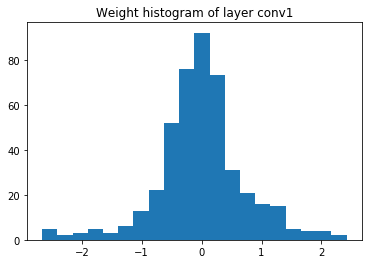

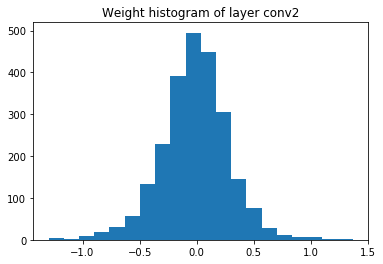

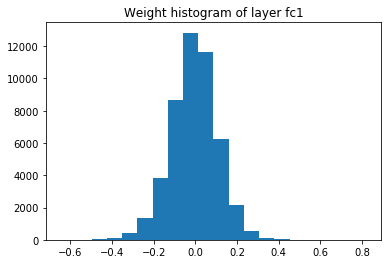

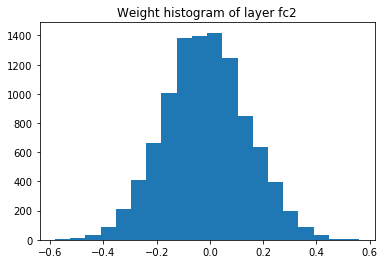

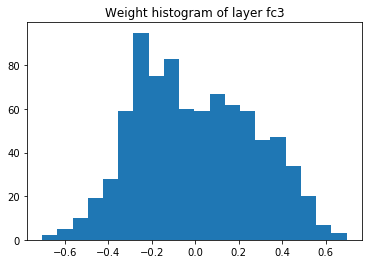

In [371]:
# L2 reg = 0.0001
for name, module in net.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Get the weight of the module as a NumPy array
        weight = module.weight.cpu().detach().numpy()  
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

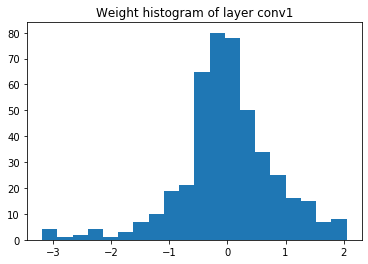

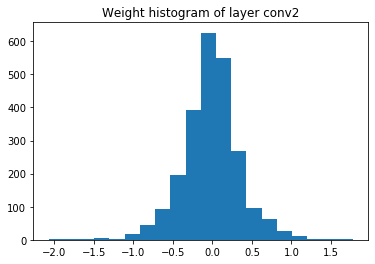

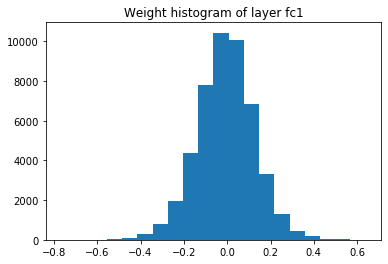

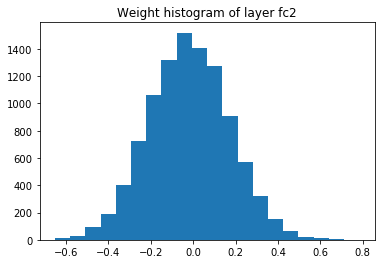

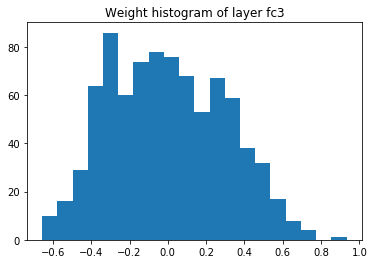

In [382]:
# L1 lamb = 1
for name, module in net.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Get the weight of the module as a NumPy array
        weight = module.weight.cpu().detach().numpy()  
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()